# QAOA mapping from the QUBO (pyquil and Rigetti)

The most known variational algorithm for combinatorial optimization is the Quantum Approximate Optimization Algorithm (QAOA) [[1]](https://arxiv.org/abs/1411.4028). The QAOA is a hybrid algorithm, i.e. it uses both a quantum component (to compute the eigenvalue of the Hamiltonian for a given state) and a classical component to change the state for the next iteration.

In the following we use the [PyQuil Rigetti framework](https://pyquil-docs.rigetti.com/en/stable/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from pyquil.simulation.tools import lifted_pauli

from entropica_qaoa.qaoa.parameters import StandardParams
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnWFSim

from scipy.optimize import minimize

Here we will tackle the problfrom described in the notebook **Quantum computing impact on the environment.ipynb**. We seek the minimum function value, and corresponding configuration of variables, for that we can use the quadratic and linear terms obatained from the **qbm** model.

In [2]:
#dictinary with the variables and respective coefficients for the linear terms:
d_linear = {'s_0g': -33225.0, 's_0s': -24060.0, 's_0w': -29820.0, 's_1g': -19830.0, 
            's_1s': -17778.0, 's_1w': -20856.0, 's_2g': -55550.0, 's_2s': -34530.0, 
            's_2w': -44760.0, 's_3g': 11425.0, 's_3s': -3120.0, 's_3w': 60.0}

In [3]:
#dictinary with the variables and respective coefficients for the quadritic terms:
d_quadratic = {('s_0s', 's_0g'): 31500.0, ('s_0w', 's_0g'): 45000.0, ('s_0w', 's_0s'): 21000.0, ('s_1g', 's_0s'): 6.0, 
               ('s_1g', 's_0w'): 6.0, ('s_1s', 's_0g'): 6.0, ('s_1s', 's_0w'): 2.0, ('s_1s', 's_1g'): 31500.0, 
               ('s_1w', 's_0g'): 6.0, ('s_1w', 's_0s'): 2.0, ('s_1w', 's_1g'): 45000.0, ('s_1w', 's_1s'): 21000.0, 
               ('s_2g', 's_1s'): 6.0, ('s_2g', 's_1w'): 6.0, ('s_2s', 's_1g'): 6.0, ('s_2s', 's_1w'): 2.0, 
               ('s_2s', 's_2g'): 31500.0, ('s_2w', 's_1g'): 6.0, ('s_2w', 's_1s'): 2.0, ('s_2w', 's_2g'): 45000.0, 
               ('s_2w', 's_2s'): 21000.0, ('s_3g', 's_2s'): 6.0, ('s_3g', 's_2w'): 6.0, ('s_3s', 's_2g'): 6.0, 
               ('s_3s', 's_2w'): 2.0, ('s_3s', 's_3g'): 31500.0, ('s_3w', 's_2g'): 6.0, ('s_3w', 's_2s'): 2.0, 
               ('s_3w', 's_3g'): 45000.0, ('s_3w', 's_3s'): 21000.0}

In [4]:
#dictionary to translate the pauli Z for each variable to be use in the Hamiltonian
zd = {k:f'Z{i+1}' for i,k in enumerate(d_linear.keys())}

### The maping from QUBO to QAOA:
On a quantum computer we measure the state of a qubit in the $\{|0⟩,|1⟩\}$ basis by applying the Z operator. However, the eigenvalues of this operator are +1 for the state $|0⟩$, and −1 for the state $|1⟩$. In order to map this to the 0,1 values of binary variables, we need to modify the measurement operator to be

$$x_i \Leftrightarrow \frac{I-Z_i}{2}$$

where I is the identity operator. With these considerations, the Hamiltonian $H$ encoding our objective function can be defined as:
$$H_t = H_{linear} + H_{squared}$$

In [5]:
#Linear hamiltonian
ham_lin_t = 0.25*PauliSum.from_compact_str('+'.join([f'({d_linear[k]})*Z{i+1} + ({d_linear[k]})*I' for i,k in enumerate(d_linear.keys())]))

In [6]:
# Squared Hamiltonian
ham_square_t1 = 0.25*PauliSum.from_compact_str('+'.join([f'({d_quadratic[k]})*{zd[k[0]]}*{zd[k[1]]}' for k in d_quadratic.keys()]))

In [7]:
# Squared Hamiltonian pt. 2
ham_square_t2 = -0.25*PauliSum.from_compact_str('+'.join([f'({d_quadratic[k]})*{zd[k[0]]} + ({d_quadratic[k]})*{zd[k[1]]} + ({-d_quadratic[k]})*I' for k in d_quadratic.keys()]))

we have:

In [9]:
ham_lin_t

(-8306.25+0j)*Z1 + (-68011+0j)*I + (-6015+0j)*Z2 + (-7455+0j)*Z3 + (-4957.5+0j)*Z4 + (-4444.5+0j)*Z5 + (-5214+0j)*Z6 + (-13887.5+0j)*Z7 + (-8632.5+0j)*Z8 + (-11190+0j)*Z9 + (2856.25+0j)*Z10 + (-780+0j)*Z11 + (15+0j)*Z12

In [10]:
ham_square_t1

(7875+0j)*Z2*Z1 + (11250+0j)*Z3*Z1 + (5250+0j)*Z3*Z2 + (1.5+0j)*Z4*Z2 + (1.5+0j)*Z4*Z3 + (1.5+0j)*Z5*Z1 + (0.5+0j)*Z5*Z3 + (7875+0j)*Z5*Z4 + (1.5+0j)*Z6*Z1 + (0.5+0j)*Z6*Z2 + (11250+0j)*Z6*Z4 + (5250+0j)*Z6*Z5 + (1.5+0j)*Z7*Z5 + (1.5+0j)*Z7*Z6 + (1.5+0j)*Z8*Z4 + (0.5+0j)*Z8*Z6 + (7875+0j)*Z8*Z7 + (1.5+0j)*Z9*Z4 + (0.5+0j)*Z9*Z5 + (11250+0j)*Z9*Z7 + (5250+0j)*Z9*Z8 + (1.5+0j)*Z10*Z8 + (1.5+0j)*Z10*Z9 + (1.5+0j)*Z11*Z7 + (0.5+0j)*Z11*Z9 + (7875+0j)*Z11*Z10 + (1.5+0j)*Z12*Z7 + (0.5+0j)*Z12*Z8 + (11250+0j)*Z12*Z10 + (5250+0j)*Z12*Z11

In [11]:
ham_square_t2

(-13127+0j)*Z2 + (-19128+0j)*Z1 + (97521-0j)*I + (-16502+0j)*Z3 + (-19131+0j)*Z4 + (-13129+0j)*Z5 + (-16504+0j)*Z6 + (-19131+0j)*Z7 + (-13129+0j)*Z8 + (-16504+0j)*Z9 + (-19128+0j)*Z10 + (-13127+0j)*Z11 + (-16502+0j)*Z12

In [12]:
ham_t = ham_lin_t + ham_square_t1 + ham_square_t2

## We can check that the eigenvalues of the Hamiltonian

In [13]:
ham_matrix = lifted_pauli(ham_t, ham_t.get_qubits())

In [15]:
print('Eigenvalues: ', np.diag(ham_matrix)) 
print('')

Eigenvalues:  [-136022. +0.j -119409.5+0.j -123992. +0.j ...  325546. +0.j  296959.5+0.j
  390084. +0.j]



From the analysis with the D-wave exact solver we have that the minimum energy computed has the value 2143, we can obtain the position for the energy value from the Hamiltonian Eigenvalues as close as the exact solver computed:

In [131]:
np.where(np.diag(ham_matrix).astype(int) <= 2162)[0][-1]

<ipython-input-131-d5ff4b0673cd>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  np.where(np.diag(ham_matrix).astype(int) <= 2162)[0][-1]


3874

In [132]:
np.diag(ham_matrix)[3874]

(2143.5+0j)

This position energy gives us the bitstring 100001011111, which can be translated to the schedule:

's_0g': 1, 's_0s': 0, 's_0w': 0, 's_1g': 0, 's_1s': 0, 's_1w': 1, 's_2g': 0, 's_2s': 1, 's_2w': 1, 's_3g': 1, 's_3s': 1, 's_3w': 1

we can compare with the D-wave's suggested one:

's_0g': 1, 's_0s': 0, 's_0w': 0, 's_1g': 0, 's_1s': 0, 's_1w': 1, 's_2g': 1, 's_2s': 1, 's_2w': 0, 's_3g': 0, 's_3s': 1, 's_3w': 0 

Let’s tackle the problem using the **StandardParams** (Entropic Labs package) parametrisation. We’ll see how we do with p=4 timesteps, using **Cobyla** as our optimiser, and the **linear_ramp_from_hamiltonian** function to set up our inital parameters.

In [16]:
p = 4
standard_params = StandardParams.linear_ramp_from_hamiltonian(ham_t,p)

In [17]:
# Set up cost function and run optimisation
cost_std = QAOACostFunctionOnWFSim(ham_t,standard_params)
res_std = minimize(cost_std, standard_params.raw(), method = 'Cobyla')

In [18]:
res_std.fun

     fun: 38752.27024174367
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 79
  status: 1
 success: True
       x: array([1.60718646, 1.49572778, 1.27681436, 0.08671201, 0.08864599,
       0.28214212, 0.43707176, 1.75097521])

We can check if the results can hold after running pseudo experiments and collect the probabilities for the bitstring correspondent to the lowest energy value computed using the Hamiltonian defined earlier:

In [133]:
def state_prob_p(p):

    """
    Applies the QAOA circuit and returns the probability of measuring the bitstring 
    """

    params_std = StandardParams.linear_ramp_from_hamiltonian(ham_t,p)
    cost_std = QAOACostFunctionOnWFSim(ham_t,params_std)
    res_std = minimize(cost_std, params_std.raw(), method = 'Cobyla')
    print(res_std.fun)
    state = cost_std.get_wavefunction(res_std.x)
    probs = state.probabilities()

    return probs[3874]

In [134]:
# Running this cell should take 2 or 3 minutes.
p_vals = np.arange(1,13)
probability_opt_state = [state_prob_p(i) for i in p_vals]

24815.859361147803
24341.99161629843
57319.94587237828
38752.27024174367
22373.978141893436
-25039.793067504852
9420.783675571758
25500.655519808086
35440.653965386555
1543.6852129157041
37863.56544511595
15355.931247532288


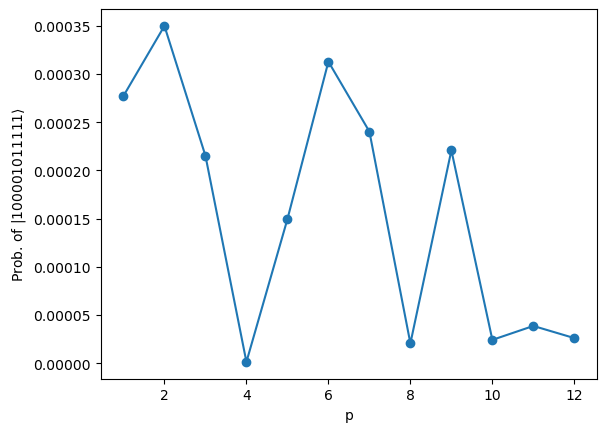

In [135]:
# Plot the probabilities
plt.plot(p_vals,probability_opt_state,'o-')
plt.xlabel('p')
plt.ylabel('Prob. of ' + r'$|100001011111\rangle$')
plt.show()

The plot above shows that the suggested bitstring might not be the best solution, a better solution can be obtained with the help of the D-wave exact solver and a new definition for the Hamiltonian.